"FC layers referenced from https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65"


In [1]:
import torch, time, os
import numpy as np
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
from sklearn.manifold import TSNE
import plotly.io as pio
from sklearn.utils import class_weight
import tqdm as notebook_tqdm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [2]:
# !pip install ipywidgets

<h3> Declare functions

In [3]:
class MyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        super(MyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.activation2 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [4]:
class FCLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCLayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.fc(x)
        return x

class ActivationLayer(nn.Module):
    def __init__(self, activation_fn):
        super(ActivationLayer, self).__init__()
        self.activation_fn = activation_fn

    def forward(self, x):
        x = self.activation_fn(x)
        return x

def tanh(x):
    return torch.tanh(x)

def sigmoid(x):
    return torch.sigmoid(x)
# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size


In [48]:
def oversample_data(X_train, Y_train, num_classes):
    # Determine the class with the maximum number of instances
    max_class_count = np.max(np.bincount(Y_train))
    # Generate indices for oversampling each class
    indices_list = [np.where(Y_train == i)[0] for i in range(num_classes)]
    # Oversample minority classes to match the count of the majority class
    for i, indices in enumerate(indices_list):
        if len(indices) < max_class_count:
            oversampled_indices = np.random.choice(indices, size=max_class_count - len(indices), replace=True)
            # Concatenate only the oversampled instances to the original data
            X_oversampled = X_train[oversampled_indices]
            Y_oversampled = Y_train[oversampled_indices]
            X_train = np.concatenate((X_train, X_oversampled), axis=0)
            Y_train = np.concatenate((Y_train, Y_oversampled), axis=0)
    return torch.tensor(X_train), torch.tensor(Y_train)

<h4> Extract train labels and label encoder

In [6]:
file_path = "data/dump/labels_train.pkl"
with open(file_path, 'rb') as file:
    y_train = pickle.load(file)
y_train = torch.tensor(y_train)
    
file_path = 'data/dump/label_decoder.pkl'
with open(file_path, 'rb') as file:
    label_decoder = pickle.load(file)

<h4> Extract test labels

In [7]:
file_path = "data/dump/labels_test.pkl"
with open(file_path, 'rb') as file:
    file = open('data/dump/labels_test.pkl', 'rb')
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

<h4> Getting BERT and GAT outputs for train

In [8]:
file_path = 'embed/u_prime_BERT_train.pkl'
with open(file_path, 'rb') as file:
    u_primes = pickle.load(file)

    concatenated_tensors = []
    for dialogue_tensor in u_primes:
        concatenated_tensors.extend(dialogue_tensor)

    tensorUtterancesTrain = torch.stack(concatenated_tensors)

file_path = "embed/h_prime_BERT-GAT_train.pkl"
with open(file_path, 'rb') as file:
    cherryPickedNodesTrain, _ = pickle.load(file)

file_path = "embed/h_prime_BERT-EGAT_train.pkl"
with open(file_path, 'rb') as file:
    allNodeFeatsTrain, _ = pickle.load(file)

<h4> Getting BERT and GAT outputs for test set

In [9]:
file_path = 'embed/u_prime_BERT_test.pkl'
with open(file_path, 'rb') as file:
    u_primes = pickle.load(file)

    concatenated_tensors = []
    for dialogue_tensor in u_primes:
        concatenated_tensors.extend(dialogue_tensor)

    tensorUtterancesTest = torch.stack(concatenated_tensors)

file_path = "embed/h_prime_BERT-GAT_test.pkl"
with open(file_path, 'rb') as file:
    cherryPickedNodesTest, _ = pickle.load(file)

file_path = "embed/h_prime_BERT-EGAT_test.pkl"
with open(file_path, 'rb') as file:
    allNodeFeatsTest, _ = pickle.load(file)
    
_ = None

<h4> Getting BERT and GAT outputs for the valid set

In [10]:
# TODO do the same code as above once you have u' and h' of valid set

EDA

In [11]:
# # Checking the structure of graph
# for n in range(10):
#     tensor_data_np = tensor_utterances[n].detach().numpy()

#     # Plot the data
#     plt.figure(figsize=(10, 5))
#     plt.plot(range(len(tensor_data_np)), tensor_data_np)
#     plt.title('Line Graph of Tensor Data')
#     plt.xlabel('Index')
#     plt.ylabel('Value')
#     plt.show()


In [12]:
# # Normalize the h' (1st GAT)
# data = cherry_picked_nodes.detach().numpy()
# data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# # Compute pairwise cosine similarities
# similarities = cosine_similarity(data_normalized)

# # Print or analyze the similarity matrix
# # print(similarities)
# plt.hist(similarities.flatten(), bins=50, density=True)
# plt.title('Distribution of Cosine Similarities')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.show()


In [13]:
# # Normalize the h' (2nd GAT)
# data = all_node_feats.detach().numpy()
# data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# # Compute pairwise cosine similarities
# similarities = cosine_similarity(data_normalized)

# # Print or analyze the similarity matrix
# # print(similarities)
# plt.hist(similarities.flatten(), bins=50, density=True)
# plt.title('Distribution of Cosine Similarities')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.show()


In [14]:
# # Normalize the u' or updated_representations
# data = tensor_utterances.detach().numpy()
# data_normalized = data / np.linalg.norm(data, axis=1, keepdims=True)

# # Compute pairwise cosine similarities
# similarities = cosine_similarity(data_normalized)

# plt.hist(similarities.flatten(), bins=50, density=True)
# plt.title('Distribution of Cosine Similarities')
# plt.xlabel('Cosine Similarity')
# plt.ylabel('Frequency')
# plt.show()


<h3> Feature Selection

In [15]:
# X_train = tensor_utterances
# Y_train = y_train

Part 1

In [16]:
# # Define the number of features (k) to select
# k = 100  # Adjust this value as needed

# # Initialize SelectKBest with the desired score function (e.g., f_classif for classification tasks)
# selector = SelectKBest(score_func=f_classif, k=k)

# # Fit SelectKBest on the training data and target variable
# selector.fit(X_train, Y_train)

# # Get the indices of the selected features
# selected_indices = selector.get_support(indices=True)

# # Get the scores of the selected features
# feature_scores = selector.scores_[selected_indices]

# # Display the scores along with their corresponding indices
# # for idx, score in zip(selected_indices, feature_scores):
# #     print(f"Feature index: {idx}, Score: {score}")

# X_train_selected = X_train[:, selected_indices]
# print(X_train_selected.shape)

Pass u' (BERT) and h' (GAT or EGAT) into this method

In [17]:
def get_norm_features(encoded_features):
    scaler = MinMaxScaler()
#       "FeatureSelected+BERT+GAT: ", concatenatedRepresentationTrain2.shape, "\n",
    features_scaled = scaler.fit_transform(encoded_features.clone().detach())
    return torch.tensor(features_scaled)

def get_selected_features(encoded_features, labels, top_n):
    # Apply Min-Max scaling to make the data non-negative
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(encoded_features)

    # Initialize SelectKBest with the desired score function (e.g., f_classif for classification tasks)
    selector = SelectKBest(score_func=f_classif, k=100)
    # Assuming feature is your feature matrix (12840 instances x 300 dimensions)
    # and y_train is your target labels

    # Initialize a dictionary to store the indices of top features for each class
    top_features_by_class = {}
    top_scores = {}
    # Calculate the relevance of each feature to each class using chi-squared test
    for label in range(7):  # Assuming you have 7 classes
        # Create a binary mask indicating instances belonging to the current class
        mask = (labels == label)

        # SelectKBest with chi2 as the scoring function
        selector = SelectKBest(score_func=chi2, k=top_n)  # Select top 20 features
        selector.fit(features_scaled, mask)  # Fit SelectKBest to the data
        # Get the indices of the top 20 features
        top_features_indices = np.argsort(selector.scores_)[-top_n:]
        scores = selector.scores_[top_features_indices]
        # Store the indices in the dictionary
        top_features_by_class[label] = top_features_indices
        top_scores[label] = scores

    # Print the top features for each class
    # for label, indices in top_features_by_class.items():
    #     print(f"Label {label_decoder[label]}: idx {', '.join(map(str, indices))}")
    #     print(top_scores[label])

    concatenated_features_set = set()
    for label, indices in top_features_by_class.items():
        concatenated_features_set.update(indices)

    concatenated_features_indices = list(concatenated_features_set)

    concatenated_features_indices = np.array(concatenated_features_indices)

    # Select the desired features
    selected_features = encoded_features[:, concatenated_features_indices]
#     print(selected_features.shape)
    return selected_features, concatenated_features_indices

Selected h'

In [18]:
# X_train = all_node_feats

In [19]:
# # Apply Min-Max scaling to make the data non-negative
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# # Initialize SelectKBest with the desired score function (e.g., f_classif for classification tasks)
# selector = SelectKBest(score_func=f_classif, k=100)
# # Assuming X_train is your feature matrix (12840 instances x 300 dimensions)
# # and y_train is your target labels

# # Initialize a dictionary to store the indices of top features for each class
# top_features_by_class = {}
# top_scores = {}
# # Calculate the relevance of each feature to each class using chi-squared test
# for label in range(7):  # Assuming you have 7 classes
#     # Create a binary mask indicating instances belonging to the current class
#     mask = (Y_train == label)

#     # SelectKBest with chi2 as the scoring function
#     selector = SelectKBest(score_func=chi2, k=20)  # Select top 20 features
#     selector.fit(X_train_scaled, mask)  # Fit SelectKBest to the data
#     # Get the indices of the top 20 features
#     top_features_indices = np.argsort(selector.scores_)[-20:]
#     scores = selector.scores_[top_features_indices]
#     # Store the indices in the dictionary
#     top_features_by_class[label] = top_features_indices
#     top_scores[label] = scores
    
# # Print the top features for each class
# for label, indices in top_features_by_class.items():
#     print(f"Label {label_decoder[label]}: idx {', '.join(map(str, indices))}")
#     print(top_scores[label])

In [20]:
# selected_features1[0]

In [21]:
# selected_features2[0]

In [22]:
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(selected_features.detach().numpy())

# # Plot the PCA result with color-coded labels
# plt.figure(figsize=(8, 6))
# for label in np.unique(Y_train):
#     indices = Y_train == label
#     plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'{label_decoder[label]}', alpha=0.5)
#     plt.title('PCA Visualization of Selected Utterance Embeddings (Train) with Color-Coded Labels')
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

3d plottly

In [23]:
# X_train = selected_features
# X_train = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
# # Perform T-SNE dimensionality reduction
# tsne = TSNE(n_components=3, random_state=42)
# X_tsne = tsne.fit_transform(X_train)

# # Create a Plotly scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=X_tsne[:, 0],
#     y=X_tsne[:, 1],
#     z=X_tsne[:, 2],
#     mode='markers',
#     marker=dict(
#         size=3,
#         color=Y_train,  # Assuming Y_train contains labels for coloring
#         colorscale='Viridis',  # You can choose a different colorscale
#         opacity=0.8
#     )
# )])

# # Update layout
# fig.update_layout(title='3D T-SNE Plot', autosize=False,
#                   width=800, height=800)

# # Show the plot
# fig.show()

In [24]:
# Save the plot as an HTML file
# pio.write_html(fig, '3d_tsne_plot.html')

Selected features of train data

In [37]:
# BERT+EGAT
selectedUPrime, BERT_trainIndices = get_selected_features(tensorUtterancesTrain, y_train, 20)
selectedHPrime, GAT_trainIndices1 = get_selected_features(allNodeFeatsTrain, y_train, 20)
concatenatedSelectedRepresentationTrain1 = torch.cat((selectedUPrime, selectedHPrime), dim=1)
# BERT+GAT
# selectedHPrime, GAT_trainIndices2 = get_selected_features(allNodeFeatsTrain, y_train, 20)
# concatenatedRepresentationTrain2 = torch.cat((selectedUPrime, selectedHPrime), dim=1)
# raw-BERT
rawCtxRepresentationTrain = get_norm_features(tensorUtterancesTrain)
# selected-BERT
# ctxRepresentationTrain = selectedUPrime

# raw-BERT+GAT 
concatenatedRepresentationTrain1 = torch.cat((get_norm_features(tensorUtterancesTrain), 
                                              get_norm_features(cherryPickedNodesTrain)), dim=1)
# raw-BERT+EGAT
concatenatedRepresentationTrain2 = torch.cat((get_norm_features(tensorUtterancesTrain), 
                                              get_norm_features(allNodeFeatsTrain)), dim=1)

# print("Sizes of different combination of train data\n",
#       "FeatureSelected+BERT+EGAT: ", concatenatedRepresentationTrain1.shape, "\n",
#       "FeatureSelected+BERT+GAT: ", concatenatedRepresentationTrain2.shape, "\n",
#       "BERT: ", rawCtxRepresentationTrain.shape, "\n",
#       "FeatureSelected+BERT: ", ctxRepresentationTrain.shape)

In [45]:
GAT_trainIndices1

array([513, 521,  12, 526, 527,  16, 528, 542,  36, 553, 563,  58,  63,
        72, 585, 587,  79, 593,  86,  90,  96, 100, 105, 620, 109, 621,
       626, 115, 627, 118, 127, 131, 645, 652, 142, 656, 145, 146, 148,
       662, 150, 156, 160, 167, 682, 683, 170, 684, 184, 699, 187, 189,
       703, 192, 705, 704, 202, 723, 213, 726, 215, 216, 732, 733, 742,
       232, 751, 240, 243, 247, 249, 763, 766, 267, 269, 271, 279, 304,
       307, 311, 312, 319, 332, 336, 345, 353, 359, 361, 381, 388, 404,
       408, 410, 413, 437, 439, 445, 458, 464, 480, 481, 482, 490, 505,
       507], dtype=int64)

Selected features of test data

In [38]:
# BERT+EGAT
selectedUPrime = tensorUtterancesTest[:, BERT_trainIndices]
selectedHPrime = allNodeFeatsTest[:, GAT_trainIndices1]
concatenatedSelectedRepresentationTest1 = torch.cat((selectedUPrime, selectedHPrime), dim=1)
# BERT+GAT
# selectedHPrime = allNodeFeatsTest[:, GAT_trainIndices2]
# concatenatedRepresentationTest2 = torch.cat((selectedUPrime, selectedHPrime), dim=1)
# raw-BERT
rawCtxRepresentationTest = get_norm_features(tensorUtterancesTest)
# selected-BERT
# ctxRepresentationTest = selectedUPrime
# raw-BERT+GAT 
concatenatedRepresentationTest1 = torch.cat((get_norm_features(tensorUtterancesTest), 
                                             get_norm_features(cherryPickedNodesTest)), dim=1)
# raw-BERT+EGAT
concatenatedRepresentationTest2 = torch.cat((get_norm_features(tensorUtterancesTest), 
                                             get_norm_features(allNodeFeatsTest)), dim=1)

# print("Sizes of different combination of train data\n",
#       "FeatureSelected+BERT+EGAT: ", concatenatedRepresentationTest1.shape, "\n",
#       "FeatureSelected+BERT+GAT: ", concatenatedRepresentationTest2.shape, "\n",
#       "BERT: ", rawCtxRepresentationTest.shape, "\n",
#       "FeatureSelected+BERT: ", ctxRepresentationTest.shape)

1. Prep data - normalize and create data loader

In [27]:
def prep_data(features, labels, isOversample):
    num_instances = len(features)
    num_classes = 7

    # Rescale input features
    # selected_features = concatenated_representation / np.linalg.norm(concatenated_representation, axis=1, keepdims=True)

    # Apply data resampling (oversampling) to balance class distribution
    if isOversample:
        X_set, Y_set = oversample_data(features, labels, num_classes)
    else:
        X_set, Y_set = features, labels

    # Calculate class weights for class weighting
#     class_counts = np.bincount(labels)
#     total_instances = np.sum(class_counts)
    # class_weights = torch.tensor([total_instances / (num_classes * count) for count in class_counts], dtype=torch.float32)

    # Convert data to PyTorch tensors
    X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
    Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()
    # print(X_train_tensor.shape, Y_train_tensor.shape)
    # X_train_tensor = torch.tensor(selected_features)
    # Y_train_tensor = torch.tensor(y_train)

    unique_labels, label_counts = np.unique(Y_set, return_counts=True)

    # Print the counts for each unique label
    for label, count in zip(unique_labels, label_counts):
        print(f"Label {label_decoder[label]}: {count} occurrences")

    print(X_tensor.shape, Y_tensor.shape)
    # Create a TensorDataset
    dataset = TensorDataset(X_tensor, Y_tensor)

    return X_tensor, Y_tensor

2. Training

In [39]:
def model_train(X_set, Y_set, input_dim, num_epochs, num_classes, loss_difference_threshold=0.3):
    hidden_dims = [512, 256]  # Hidden layer dimensions
    output_dim = num_classes  # Number of classes
    dropout_rate = 0.5  # Dropout rate for regularization
    # Initialize the model
    model = MyNetwork(input_dim, hidden_dims, output_dim, dropout_rate)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    # Lists to store loss and accuracy for plotting
    loss_history = []
    accuracy_history = []
    # Train the model
    print_interval = 1  # Print tqdm every epoch
    previous_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0.0
        correct_predictions = 0
        total_instances = 0
        # Use tqdm for progress tracking
        with tqdm(total=len(X_set), desc=f'Epoch {epoch+1}/{num_epochs}', leave=False) as pbar:
            for inputs, labels in zip(X_set, Y_set):
                inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
                labels = torch.tensor(labels.clone().detach(), dtype=torch.long)
                # Forward pass
                outputs = model(inputs)
                # Flatten the outputs and labels if necessary
                outputs = outputs.squeeze()
                labels = labels.squeeze()
                # Calculate loss
                loss = criterion(outputs, labels)
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                # Update metrics
                total_loss += loss.item()
                _, predicted = torch.max(outputs, dim=0)  # Use dim=0 for single output
                correct_predictions += (predicted == labels).sum().item()
                total_instances += 1
                pbar.update(1)

        # Calculate epoch loss and accuracy
        epoch_loss = total_loss / total_instances
        epoch_accuracy = correct_predictions / total_instances
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)

        # Print average loss and accuracy per epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Check if difference in loss exceeds threshold
        if epoch > 0 and abs(epoch_loss - previous_loss) < loss_difference_threshold:
            print(f'Training terminated early at epoch {epoch+1} due to small change in loss')
            break

        previous_loss = epoch_loss

    # Plot loss and accuracy over epochs
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

In [29]:
def classify_emotions(model, X_tensor, Y_tensor, isTrain):
    # Set the model to evaluation mode
    model.eval()

    # Predict on the data
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs, 1)

    # Convert predicted tensor to numpy array
    predicted = predicted.numpy()

    # Calculate classification report
    report = classification_report(Y_tensor, predicted, target_names=label_decoder.values(), output_dict=True, zero_division=0)

    # Print classification report
    for label, metrics in report.items():
        if label != 'accuracy':  # Skip printing accuracy as it's a separate metric
            print(f'Class: {label}')
            print(f'Precision: {metrics["precision"]:.4f}')
            print(f'Recall: {metrics["recall"]:.4f}')
            print(f'F1 Score: {metrics["f1-score"]:.4f}')
            print()

    # Print accuracy
    print(f'Accuracy: {report["accuracy"]:.4f}')

    # Print weighted F1 score
    print(f'Weighted F1 Score: {report["weighted avg"]["f1-score"]:.4f}')

In [30]:
# TODO create table of loss and accuracy during training
# TODO also compute the time it takes to complete the train

<h4> Train and validate BERT+EGAT given 15 epochs

In [31]:
# enable oversampling by setting isOversample=True
X_trainTensor, Y_trainTensor = prep_data(concatenatedRepresentationTrain2, y_train, False)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=15, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Train BERT+EGAT given 15 epochs - Elapsed time: {elapsed_time} seconds")

C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 1500 occurrences
Label disgust: 364 occurrences
Label fear: 338 occurrences
Label joy: 2312 occurrences
Label neutral: 5960 occurrences
Label sadness: 876 occurrences
Label surprise: 1490 occurrences
torch.Size([12840, 1536]) torch.Size([12840])


Epoch 1/15:   0%|                                                                            | 0/12840 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\217854138.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\217854138.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/15], Loss: 1.5091, Accuracy: 0.4731


Epoch [2/15], Loss: 1.3815, Accuracy: 0.5136


Epoch [3/15], Loss: 1.3288, Accuracy: 0.5402


Epoch [4/15], Loss: 1.2673, Accuracy: 0.5711


Epoch [5/15], Loss: 1.2343, Accuracy: 0.5836


Epoch [6/15], Loss: 1.2131, Accuracy: 0.5888


Epoch [7/15], Loss: 1.1997, Accuracy: 0.5986


Epoch [8/15], Loss: 1.1889, Accuracy: 0.5986


Epoch [9/15], Loss: 1.1818, Accuracy: 0.6035


Epoch [10/15], Loss: 1.1711, Accuracy: 0.6055


Epoch [11/15], Loss: 1.1643, Accuracy: 0.6087


Epoch [12/15], Loss: 1.1580, Accuracy: 0.6114


Epoch [13/15], Loss: 1.1517, Accuracy: 0.6129


Epoch [14/15], Loss: 1.1461, Accuracy: 0.6166


Epoch [15/15], Loss: 1.1435, Accuracy: 0.6164
Train BERT+EGAT given 15 epochs - Elapsed time: 4116.868496417999 seconds


In [32]:
# Predict the test set
# classify_emotions(fcClf, X_trainTensor, Y_trainTensor, False)
X_testTensor, Y_testTensor = prep_data(concatenatedRepresentationTest2, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 1536]) torch.Size([3400])
Class: anger
Precision: 0.4592
Recall: 0.4360
F1 Score: 0.4473

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.5913
Recall: 0.3859
F1 Score: 0.4670

Class: neutral
Precision: 0.7089
Recall: 0.8415
F1 Score: 0.7695

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.3642
Recall: 0.6932
F1 Score: 0.4775

Class: macro avg
Precision: 0.3034
Recall: 0.3367
F1 Score: 0.3088

Class: weighted avg
Precision: 0.5302
Recall: 0.5938
F1 Score: 0.5508

Accuracy: 0.5938
Weighted F1 Score: 0.5508


C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


<h4> Train and validate BERT+GAT given 2 epoch

In [36]:
X_trainTensor, Y_trainTensor = prep_data(concatenatedRepresentationTrain1, y_train, True)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=11, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Trai BERT+GAT given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 5960 occurrences
Label disgust: 5960 occurrences
Label fear: 5960 occurrences
Label joy: 5960 occurrences
Label neutral: 5960 occurrences
Label sadness: 5960 occurrences
Label surprise: 5960 occurrences
torch.Size([41720, 1536]) torch.Size([41720])


Epoch 1/15:   0%|                                                                            | 0/41720 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\217854138.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


KeyboardInterrupt: 

In [ ]:
# Predict the test set
X_testTensor, Y_testTensor = prep_data(concatenatedRepresentationTest1, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

<h4> Train and validate BERT (❌ feature selection) given 2 epochs

In [ ]:
X_trainTensor, Y_trainTensor = prep_data(rawCtxRepresentationTrain, y_train, True)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=11, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training BERT given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

In [ ]:
# Predict the test set
X_testTensor, Y_testTensor = prep_data(rawCtxRepresentationTest, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

<h4> Train and validate BERT+EGAT (⭕️ feature selection, ⭕️ Oversample) given 11 epochs

C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 5960 occurrences
Label disgust: 5960 occurrences
Label fear: 5960 occurrences
Label joy: 5960 occurrences
Label neutral: 5960 occurrences
Label sadness: 5960 occurrences
Label surprise: 5960 occurrences
torch.Size([41720, 210]) torch.Size([41720])


Epoch 1/2:   0%|                                                                             | 0/41720 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\2969156530.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\2969156530.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/2], Loss: 0.4437, Accuracy: 0.8603


Epoch [2/2], Loss: 0.4070, Accuracy: 0.8717


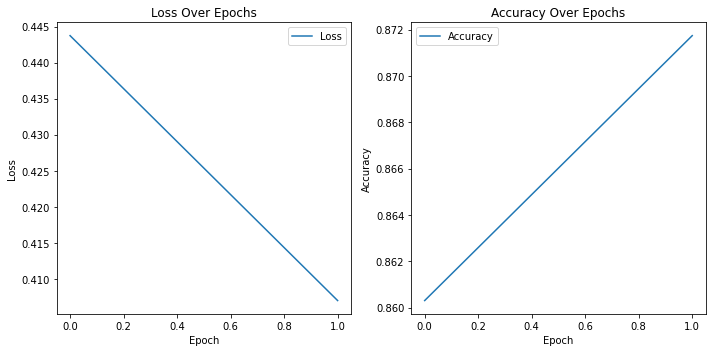

Training BERT given 15 epochs - Elapsed time: 449.64174604415894 seconds
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1429
Recall: 1.0000
F1 Score: 0.2500

Class: macro avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Class: weighted avg
Precision: 0.0204
Recall: 0.1429
F1 Score: 0.0357

Accuracy: 0.1429
Weighted F1 Score: 0.0357


In [49]:
X_trainTensor, Y_trainTensor = prep_data(concatenatedSelectedRepresentationTrain1, y_train, True)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=2, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training BERT given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

In [44]:
# # Predict the test set
X_testTensor, Y_testTensor = prep_data(concatenatedSelectedRepresentationTest1, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 210]) torch.Size([3400])
Class: anger
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: disgust
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: fear
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: joy
Precision: 1.0000
Recall: 0.0020
F1 Score: 0.0040

Class: neutral
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: sadness
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Class: surprise
Precision: 0.1037
Recall: 1.0000
F1 Score: 0.1878

Class: macro avg
Precision: 0.1577
Recall: 0.1431
F1 Score: 0.0274

Class: weighted avg
Precision: 0.1563
Recall: 0.1038
F1 Score: 0.0200

Accuracy: 0.1038
Weighted F1 Score: 0.0200


C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


<h4> Train and validate BERT+EGAT (⭕️ feature selection, ❌ Oversample) given 11 epochs¶

C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()


Label anger: 1500 occurrences
Label disgust: 364 occurrences
Label fear: 338 occurrences
Label joy: 2312 occurrences
Label neutral: 5960 occurrences
Label sadness: 876 occurrences
Label surprise: 1490 occurrences
torch.Size([12840, 210]) torch.Size([12840])


Epoch 1/11:   0%|                                                                            | 0/12840 [00:00<?, ?it/s]C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\2969156530.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs.clone().detach(), dtype=torch.float32)
C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\2969156530.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels.clone().detach(), dtype=torch.long)


Epoch [1/11], Loss: 1.2762, Accuracy: 0.5670


Epoch [2/11], Loss: 1.1822, Accuracy: 0.6037


Epoch [3/11], Loss: 1.1410, Accuracy: 0.6146


Epoch [4/11], Loss: 1.1084, Accuracy: 0.6242


Epoch [5/11], Loss: 1.0784, Accuracy: 0.6326


Epoch [6/11], Loss: 1.0440, Accuracy: 0.6403


Epoch [7/11], Loss: 1.0113, Accuracy: 0.6532


Epoch [8/11], Loss: 0.9782, Accuracy: 0.6649


Epoch [9/11], Loss: 0.9461, Accuracy: 0.6775


Epoch [10/11], Loss: 0.9063, Accuracy: 0.6874


Epoch [11/11], Loss: 0.8707, Accuracy: 0.7032


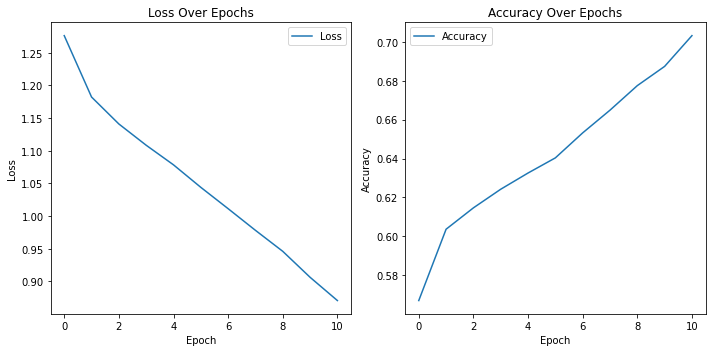

Training BERT given 15 epochs - Elapsed time: 629.3887054920197 seconds
Class: anger
Precision: 0.5249
Recall: 0.5193
F1 Score: 0.5221

Class: disgust
Precision: 0.3672
Recall: 0.3874
F1 Score: 0.3770

Class: fear
Precision: 0.5156
Recall: 0.0976
F1 Score: 0.1642

Class: joy
Precision: 0.6802
Recall: 0.5346
F1 Score: 0.5987

Class: neutral
Precision: 0.7203
Recall: 0.9166
F1 Score: 0.8067

Class: sadness
Precision: 0.5930
Recall: 0.2694
F1 Score: 0.3705

Class: surprise
Precision: 0.6871
Recall: 0.5114
F1 Score: 0.5864

Class: macro avg
Precision: 0.5841
Recall: 0.4623
F1 Score: 0.4894

Class: weighted avg
Precision: 0.6623
Recall: 0.6737
F1 Score: 0.6516

Accuracy: 0.6737
Weighted F1 Score: 0.6516


In [40]:
X_trainTensor, Y_trainTensor = prep_data(concatenatedSelectedRepresentationTrain1, y_train, False)

start_time = time.time()

fcClf = model_train(X_set=X_trainTensor, 
                    Y_set=Y_trainTensor,
                    input_dim=X_trainTensor.shape[1], 
                    num_epochs=11, 
                    num_classes=7)

end_time = time.time()
elapsed_time = end_time - start_time

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training BERT given 15 epochs - Elapsed time: {elapsed_time} seconds")

classify_emotions(fcClf, X_trainTensor, Y_trainTensor, True)

In [42]:
# # Predict the test set
X_testTensor, Y_testTensor = prep_data(concatenatedSelectedRepresentationTest1, y_test, False)
classify_emotions(fcClf, X_testTensor, Y_testTensor, False)

Label anger: 516 occurrences
Label disgust: 99 occurrences
Label fear: 60 occurrences
Label joy: 495 occurrences
Label neutral: 1615 occurrences
Label sadness: 263 occurrences
Label surprise: 352 occurrences
torch.Size([3400, 210]) torch.Size([3400])
Class: anger
Precision: 0.5181
Recall: 0.4438
F1 Score: 0.4781

Class: disgust
Precision: 0.2105
Recall: 0.2424
F1 Score: 0.2254

Class: fear
Precision: 0.3333
Recall: 0.0500
F1 Score: 0.0870

Class: joy
Precision: 0.5352
Recall: 0.4909
F1 Score: 0.5121

Class: neutral
Precision: 0.6855
Recall: 0.8650
F1 Score: 0.7649

Class: sadness
Precision: 0.3662
Recall: 0.0989
F1 Score: 0.1557

Class: surprise
Precision: 0.5662
Recall: 0.4375
F1 Score: 0.4936

Class: macro avg
Precision: 0.4593
Recall: 0.3755
F1 Score: 0.3881

Class: weighted avg
Precision: 0.5811
Recall: 0.6106
F1 Score: 0.5817

Accuracy: 0.6106
Weighted F1 Score: 0.5817


C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_set.clone().detach(), dtype=torch.float32).clone().detach()
C:\Users\edayo\AppData\Local\Temp\ipykernel_28788\3259066277.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_tensor = torch.tensor(Y_set.clone().detach(), dtype=torch.long).clone().detach()
